# Encoding networks topology, and optimizing it

In this notebook, we will show how we can encode a classical **layered network** into an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix).

To perform the forward pass of the network, we just have to **iterate this matrix** a few times, while applying for example a ReLU after each matrix multiplication.

This of course make no sense in terms of performance, as we get a large matrix with lots of zeros.

But if we have good sparse matrix primitives, in can be quite similar in terms of performance.

What's more interesting, is that if we have some good method to optimize the sparsity pattern, we can **let the network topology change with time**: we just fix the number of iterations, but the **concept of layers is no more relevant**: we can just say that there is a maximum number of neurons between the input and the output, limited by the number of iterations we chose.

We could even randomize this number, so the network will be able to give successive approximations when we iterate.


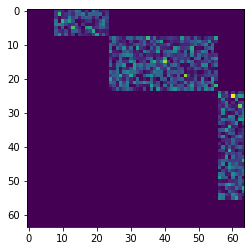

In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

def block_mask(sparsity, blocks = None, size = (64, 64), block_size = 8):
    assert((size[0] % block_size) == 0)
    assert((size[1] % block_size) == 0)
    m = torch.zeros(((size[0] // block_size), size[1] // block_size))
    
    if blocks != None:
        for b in blocks:
            m[b[0],b[1]] = 1
    else:
        m = torch.rand(size[0] // block_size, size[1] // block_size)
        m = (m > sparsity) 
        
    m = np.repeat(np.repeat(m, repeats=block_size, axis=0), repeats=block_size, axis = 1)
    return m
    
    
blocks = []

def add_layer(blocks, offset=(0,0), size=(1,1)):
    for i in range(size[0]):
        for j in range(size[1]):
            blocks.append((i+offset[0], j + offset[1]))

layer_sizes = [8,16,32,8]
offset = np.array([0, layer_sizes[0]])
for i in range(len(layer_sizes) - 1):
    size = layer_sizes[i:i+2]
    add_layer(blocks, offset=offset, size=size)
    offset += size

block_size = 1
full_size = sum(layer_sizes) * block_size
bm = block_mask(0.8, blocks, size = (full_size, full_size), block_size = block_size)
conventional_multilayer_matrix = torch.randn(full_size,full_size).abs()
conventional_multilayer_matrix *= bm
plt.imshow(conventional_multilayer_matrix)


### This matrix represent a 3 layers network:
- input layer size: 8
- first layer output size: 16
- second layer output size: 32
- third layer output size = final output size: 8

We have mapped each 'signal' to a 1D coordinate in the input vector:
- input data is from 0-8
- first layer ouput is from 8 to 24
- second layer output is from 24 to 56
- third layer output = final output is from 56 to 64

### Let's  see what happens when we iterate the matrix

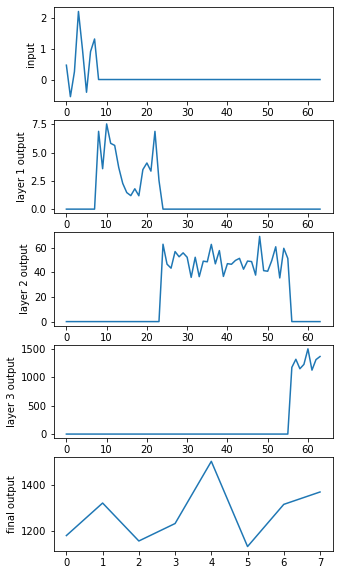

In [3]:
def forward_layers(input_state, matrix, iterations, last_layer_size, name):
    state = input_state
    fig, axes = plt.subplots(iterations + 2, 1, figsize=(5,10))

    axes[0].plot(state)
    axes[0].set_ylabel("input")

    for l in range(iterations):    
        state = state.matmul(matrix)
        state = torch.nn.functional.relu(state)
        axes[l+1].plot(state)
        axes[l+1].set_ylabel(name % (l+1))
        
    axes[-1].plot(state[-last_layer_size:])
    axes[-1].set_ylabel(f"final output")

    return state
  
def forward(input, matrix, iterations, last_layer_size, name):
    input_state = torch.zeros(full_size)
    input_state[:input.shape[0]] = input
    output_state = forward_layers(input_state, matrix, iterations, last_layer_size, name)
    output = output_state[-layer_sizes[0] * block_size:]
    return output


# Fill the first dimensions with the input
input = torch.randn(layer_sizes[0] * block_size)

output = forward(input,
                 conventional_multilayer_matrix,
                 len(layer_sizes) - 1, 
                 layer_sizes[-1] * block_size,
                 "layer %d output")



### We see that indeed each layer is activated after the other

### What happens when we use a random matrix with lots of zeros ?

torch.Size([64, 64])


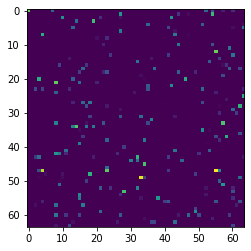

In [4]:
bm2 = block_mask(0.95, blocks = None, size = (full_size, full_size), block_size = block_size)
print(bm2.shape)
arbitrary_matrix = torch.randn((full_size,full_size)).abs()
arbitrary_matrix *= bm2


plt.imshow(arbitrary_matrix)

### We can iterate once:

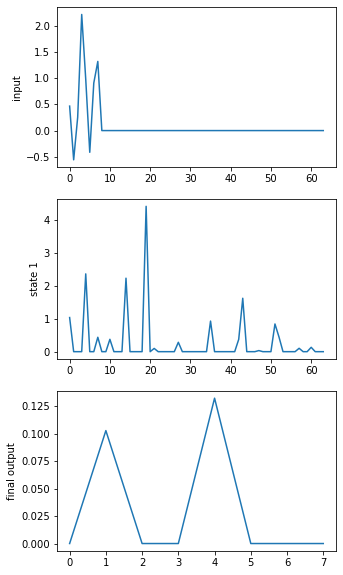

In [5]:
iterations = 1
output = forward(input, arbitrary_matrix, iterations, layer_sizes[0] * block_size, "state %d")

### Or we can iterate several times

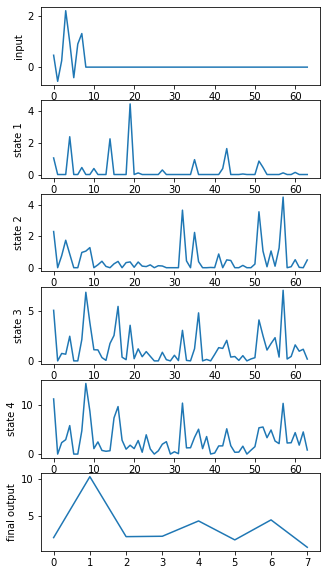

In [7]:
iterations = 4
output = forward(input, arbitrary_matrix, iterations, layer_sizes[0] * block_size, "state %d")

### Conclusion

We can encode the topology of the network in the sparsity pattern. If we have good optimization strategies for the sparse pattern, it would be equivalent to optimize for the number of units per layer and the number of layers (actually the network is not really a layered network anymore, as there may be shortcuts a la ResNet, loops etc).

We can too balance the number of units across different parts of the network, if we allocate non-zeros across the full network, making some parts more sparse than others.

It could be good a way to remove hyperparameter search when trying different topologies for parts of the network.